# Diabetes Prediction Dataset

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [3]:
def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [33]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [5]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [6]:
df.duplicated().sum()

3854

In [34]:
df.drop_duplicates(inplace=True)

In [10]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [9]:
df["smoking_history"].value_counts()

smoking_history
never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: count, dtype: int64

### Notice the convoluted language here, what does 'ever' mean here? Also what is the different between former and not current? Is there an amount of days divider that separates the two categories? It might be a good idea to consolidate some of these categories until we get more information. This is why SME's can offer great insight

### In this case, we should possibly combine ever + former + not current + current. Until we get more robust information. However, my guess is that there is a divider of days that is significant in terms of predicting if someone is between a former and on/off smoker

In [13]:
df["gender"].value_counts()

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64

In [15]:
calculate_entropy(df)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
entropy,0.981835,6.332719,0.393668,0.24596,2.15991,9.569614,3.787083,3.865964,0.4305


In [18]:
target = df.values[:,-1]

counter = Counter(target)
for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%d, Count=%d, Percentage=%d.3%%" % (k,v, per))

Class=0, Count=87664, Percentage=91.3%
Class=1, Count=8482, Percentage=8.3%


### We have an imbalanced dataset therefore we will have to incoporate under + over sampling methods and choose the best model

# Data Preparation

In [35]:
df["gender"] = df["gender"].apply(lambda x: 0 if x == "Female" else 1 if x == "Male" else 2 )
df["smoking_history"] = df["smoking_history"].apply(lambda x: 0 if x == "No Info" else 1 if x in ["former", "ever", "not current", "current"] else 2 )

<Axes: xlabel='gender'>

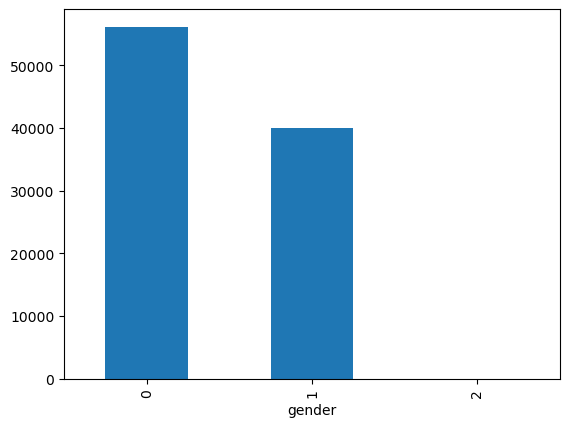

In [36]:
df["gender"].value_counts().plot.bar()

<Axes: xlabel='heart_disease'>

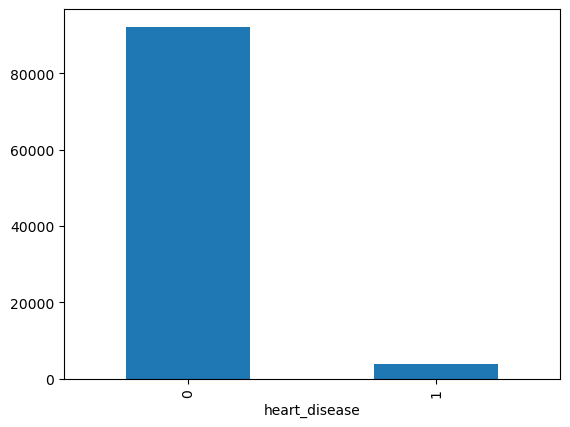

In [37]:
df["heart_disease"].value_counts().plot.bar()

### It is important to note that heart disease is also imbalanced

<Axes: xlabel='smoking_history'>

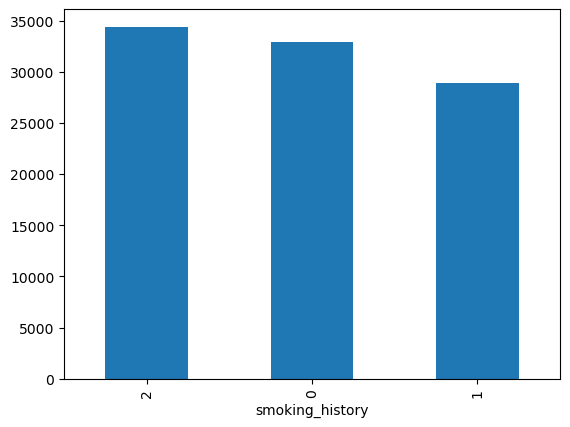

In [38]:
df["smoking_history"].value_counts().plot.bar()

In [39]:
df["smoking_history"].value_counts()

smoking_history
2    34398
0    32887
1    28861
Name: count, dtype: int64

# Visuals

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/18781

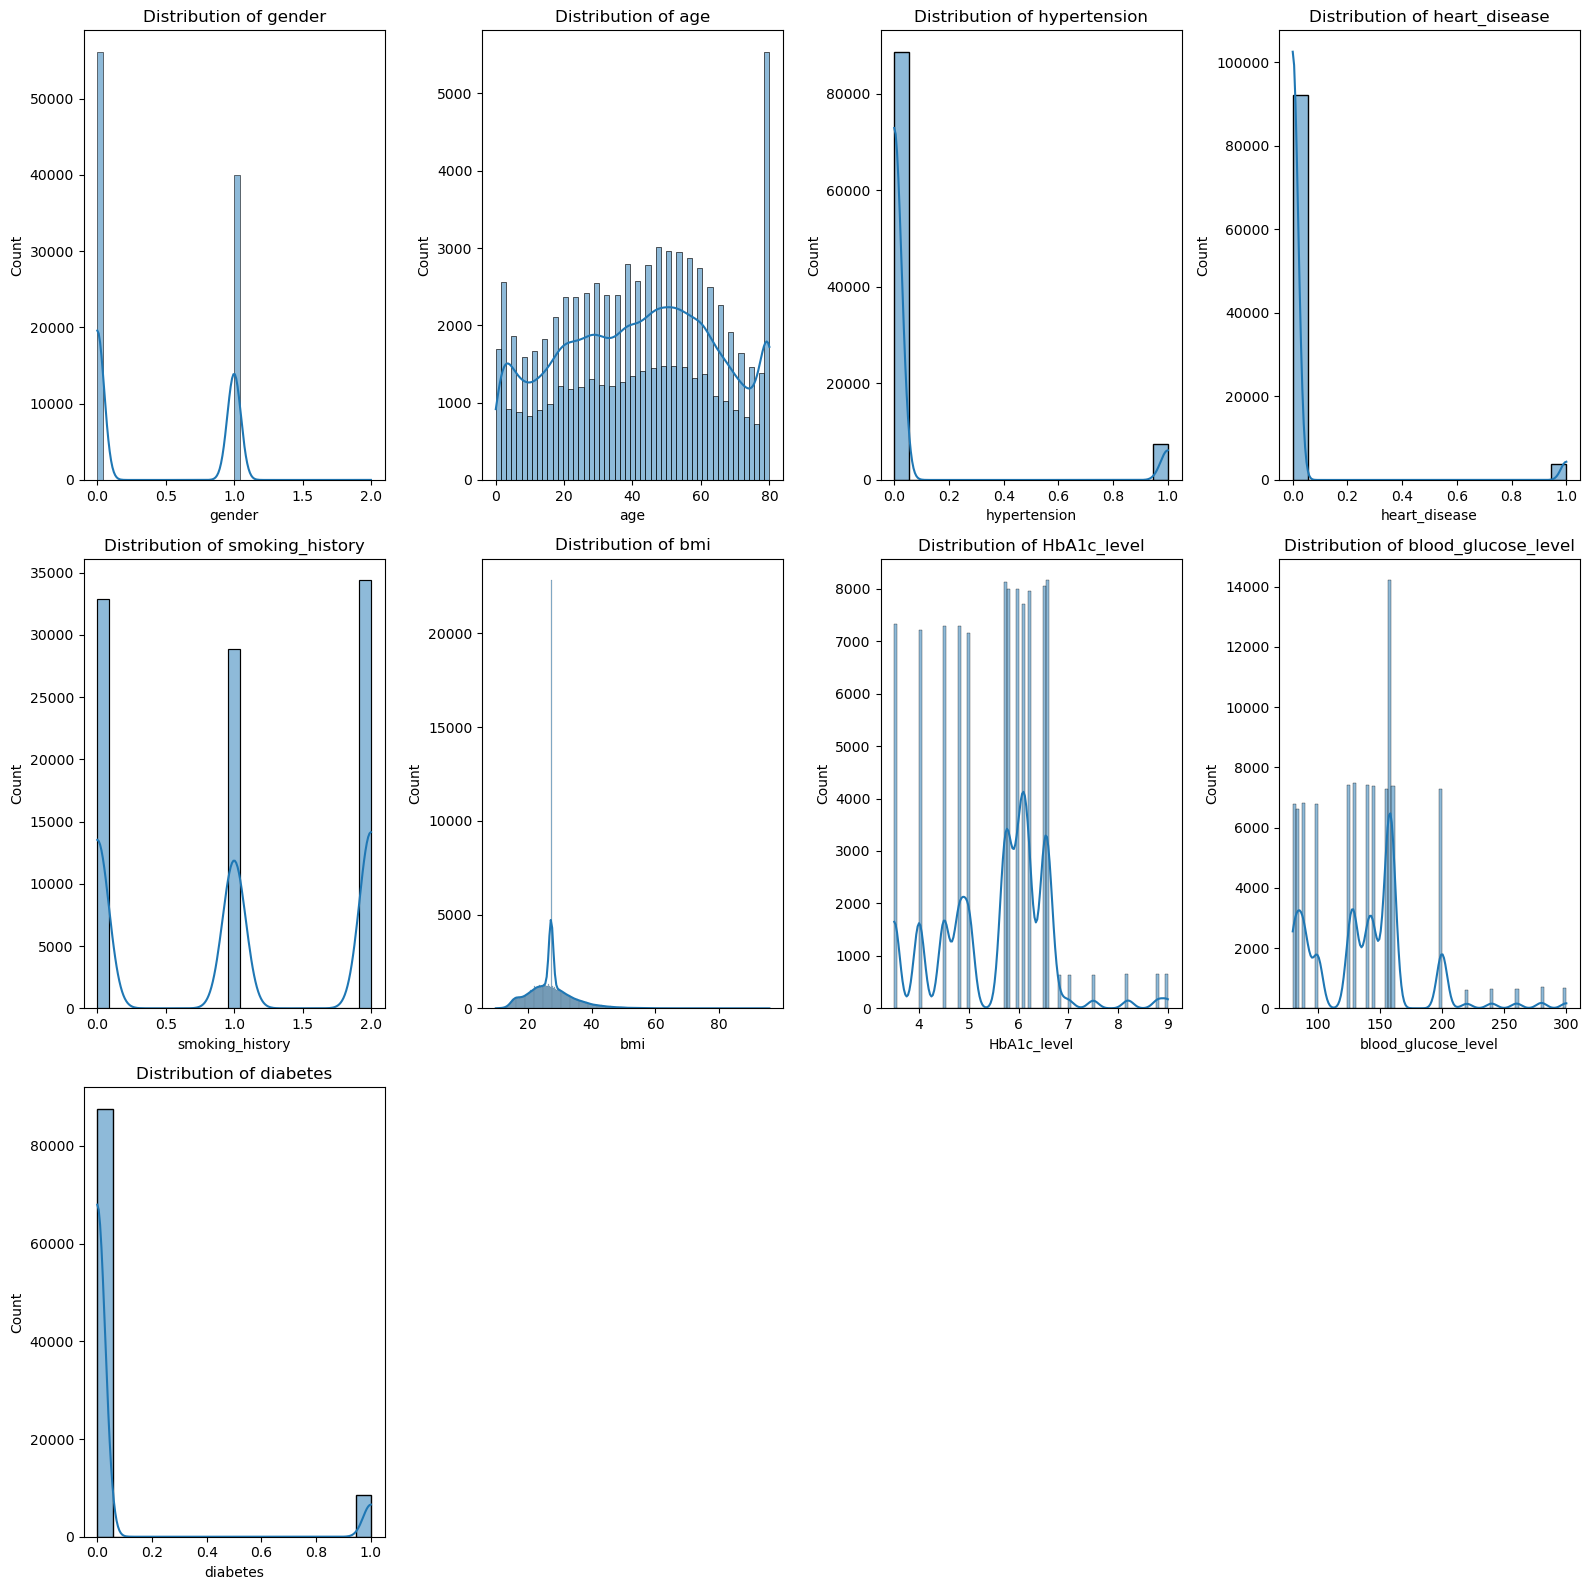

In [40]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/3390829395.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_65101/33908

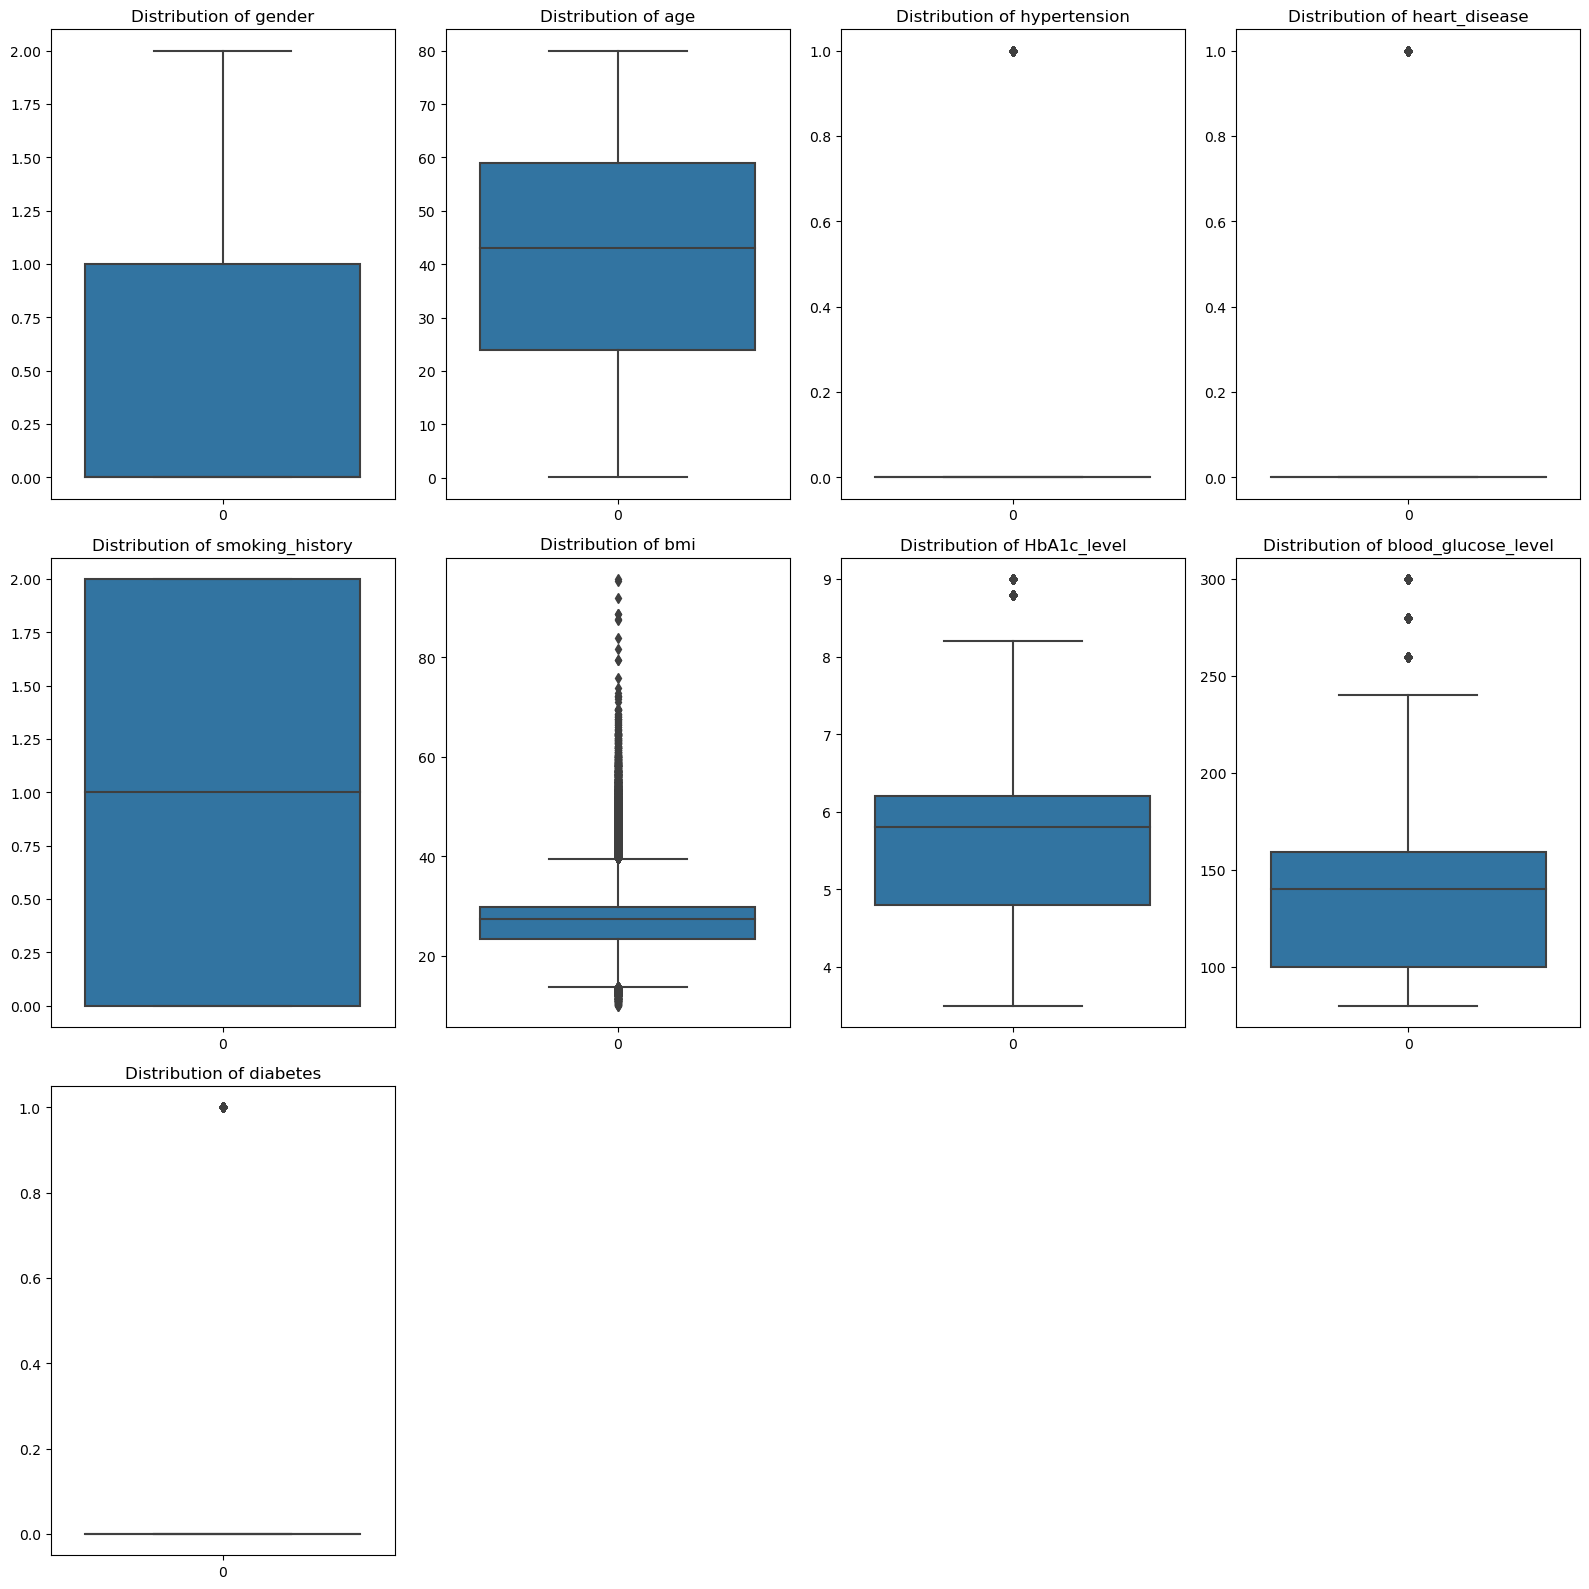

In [41]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

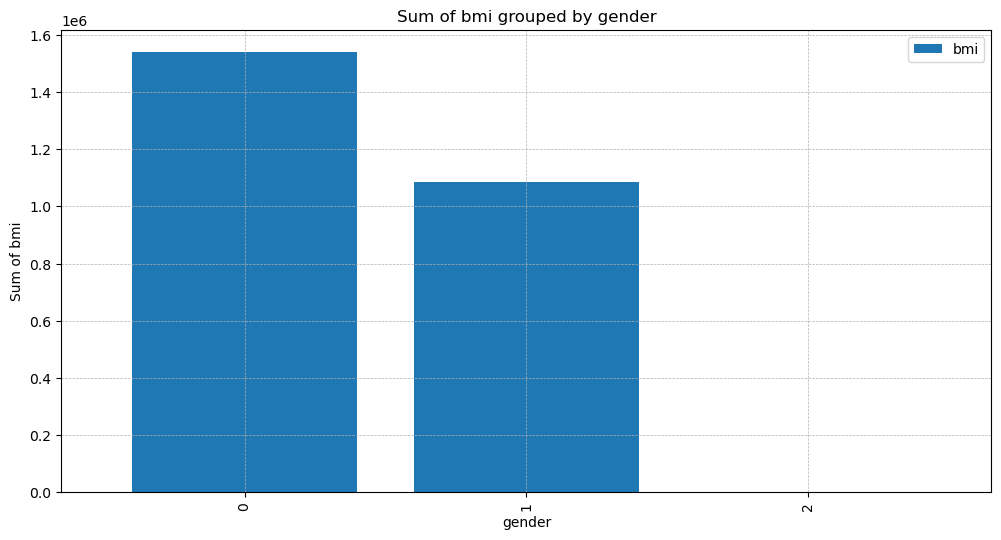

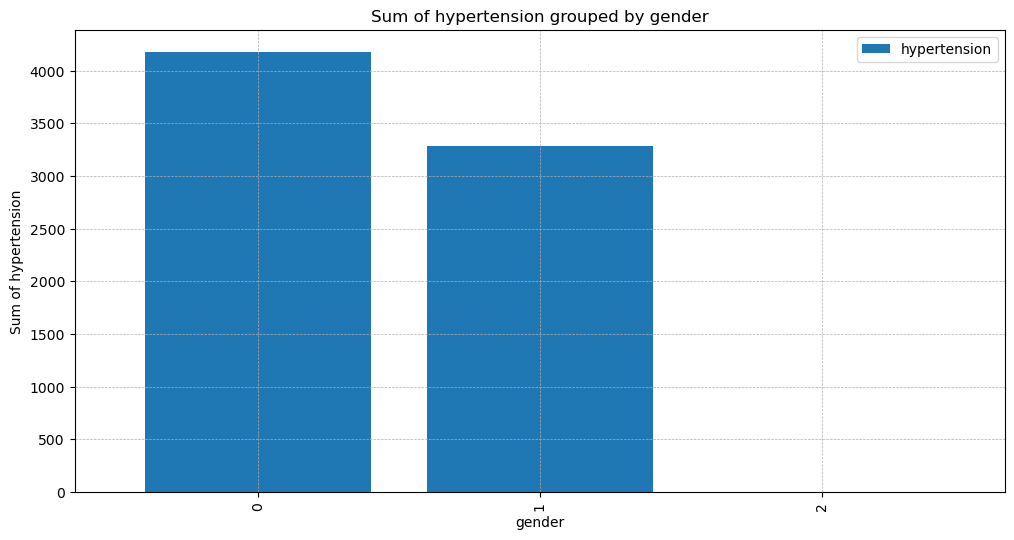

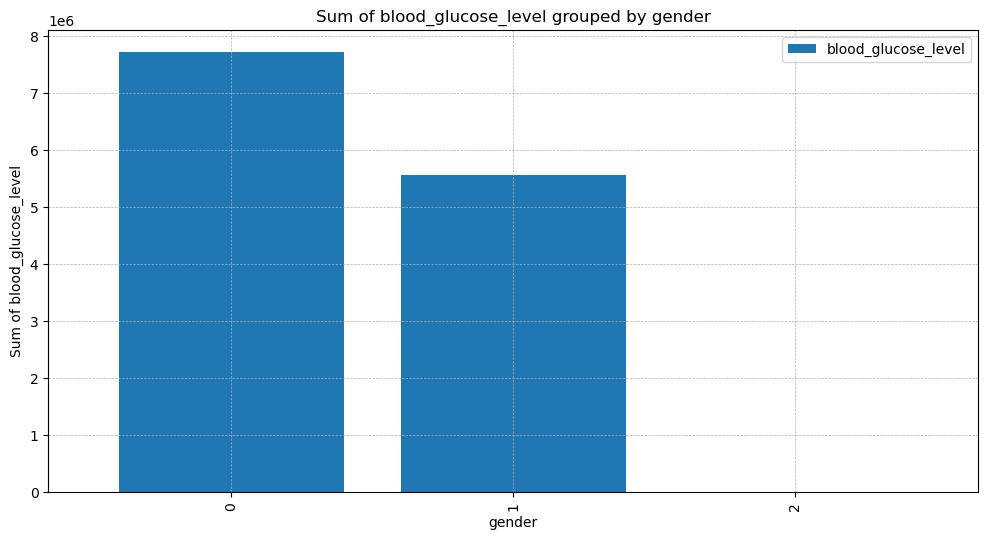

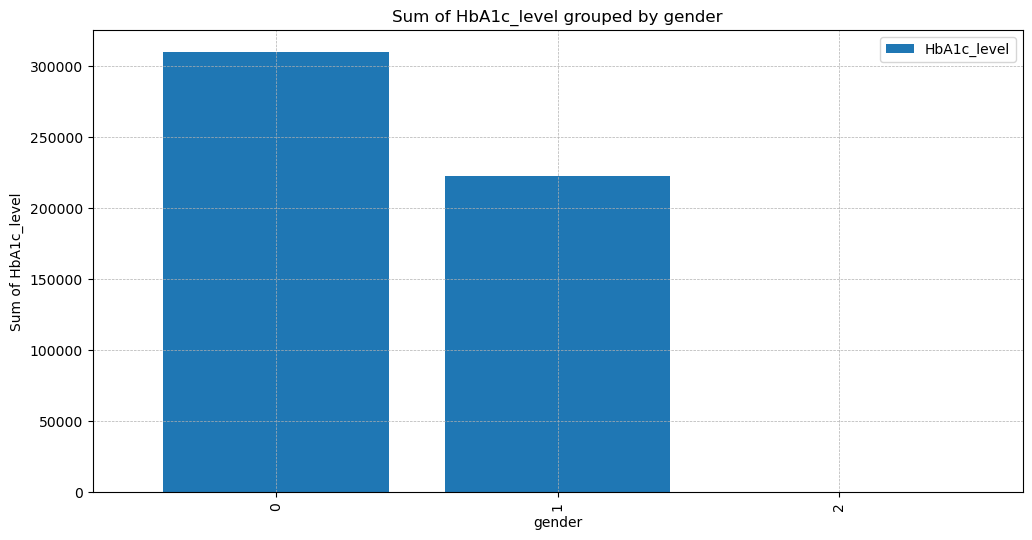

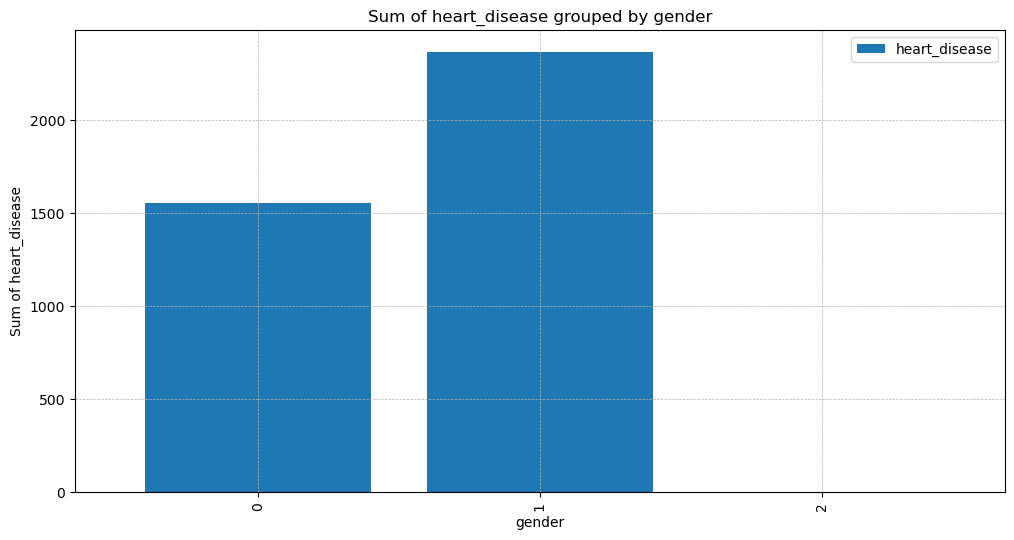

In [44]:
# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["bmi", "hypertension", "blood_glucose_level", "HbA1c_level", "heart_disease"]

for col in interested_columns:
    df_grouped = df.groupby("gender")[col].sum().reset_index()
    
    # Create the plot
    df_grouped.plot(kind="bar", x="gender", y=col, width=0.8) # Adjust bar width as needed
    
    # Set labels and title
    plt.xlabel("gender")
    plt.ylabel(f"Sum of {col}")
    plt.title(f"Sum of {col} grouped by gender")
    
    # Add gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()